In [1]:
# import required libraries
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import KElbowVisualizer

#import data
# matches = pd.read_csv('test_player.csv')
# champions = pd.read_csv('hero_names_category.csv')
# heroes = pd.read_csv('hero_names.csv')
# #import data
matches = pd.read_csv('./dota-2-matches/test_player.csv')
champions = pd.read_csv('./dota-2-matches/hero_names_category.csv')
heroes = pd.read_csv('./dota-2-matches/hero_names.csv')

In [2]:
#remove account_id column
matches = matches.drop("account_id",axis=1)

In [3]:
#Returns a map of heroId to name
def mapId2Name():
    mapheroes = {}
    for row in heroes.itertuples():
        mapheroes[row.hero_id] = row.localized_name
    return mapheroes

#Returns a map of name to Id
def mapName2Id():
    mapId = {}
    for row in heroes.itertuples():
        mapheroes[row.localized_name] = row.hero_id
    return mapId


def searchHeroName(heroId):
    mapToReturn = mapId2Name()
    return mapToReturn[heroId]


def searchHeroId(heroName):
    mapToReturn = mapName2Id()
    return mapToReturn[heroName]

In [4]:
#understanding player slot
matches.head(n=5)

,match_id,hero_id,player_slot
0,50000,96,0
1,50000,84,1
2,50000,46,2
3,50000,85,3
4,50000,39,4


In [5]:
#collapse data into columns
#The interpretation of this table is that the row represent that particular match ID. The column names are the player
#slots. They are not the individual players but rather the slots that the players play in. 
#The value within each cell is the hero id. 
competitor_rows = pd.pivot_table(matches, values='hero_id', index=['match_id'], columns='player_slot')
competitor_rows.head(n=5)

player_slot,0,1,2,3,4,128,129,130,131,132
match_id,,,,,,,,,,
50000,96,84,46,85,39,9,75,106,74,62
50001,44,10,57,2,106,58,61,21,18,14
50002,74,7,42,99,88,69,8,25,26,79
50003,44,15,110,56,94,2,101,32,7,72
50004,98,26,73,51,46,2,106,50,65,21


In [6]:
#Current each row consists of two teams. Therefore, we split dataframe vertically to separate the two teams.
#The 2nd section of the dataframe now gets appended to the end of the 1 section.
#Each row in the resultant dataframe corresponds with only one team rather than two.
section = competitor_rows
sectionA,sectionB  = np.split(section, 2, axis=1)
sectionB.columns = sectionA.columns
sectionA.append(sectionB,ignore_index = True)
sectionA.head(n=5)

player_slot,0,1,2,3,4
match_id,,,,,
50000,96,84,46,85,39
50001,44,10,57,2,106
50002,74,7,42,99,88
50003,44,15,110,56,94
50004,98,26,73,51,46


In [7]:
#The table above now gets transformed into a binary matrix. Each column name corresponds to the hero id. 
#Each row corresponds to a particular match id. However, it's worth mentioning that the match id values gets reset to 
#start at one but the current situation does not consider the match id for clustering so the result is not affected. 

#The interpretation of the binary matrix starts off with each row representing a match for one team
#Each column in the binary matrix corresponds to a hero Id
#The value of each cell represent whether that particular hero is chosen for that particular match 
#for that specific team.

#It's worth mentioning that the dataframe starts off at column index 0. However, hero Ids start off at 1 
#This means that every player's index is offset by one. This situation has been accounted for. 

dataset=[]
for row in sectionA.iterrows():
    index, data = row
    dataset.append(data.tolist())
#it transforms the input dataset (a Python list of lists) into a one-hot encoded NumPy boolean array
oht = TransactionEncoder()
oht_ary = oht.fit(dataset).transform(dataset)
df = pd.DataFrame(oht_ary, columns=oht.columns_)
df.head(n=5)

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,109,110,111,112
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
#Converting the binary string matrix to a binary integer matrix
# 0: False
# 1: True
df = df*1
df.head()

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,109,110,111,112
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/Users/Cosimo/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


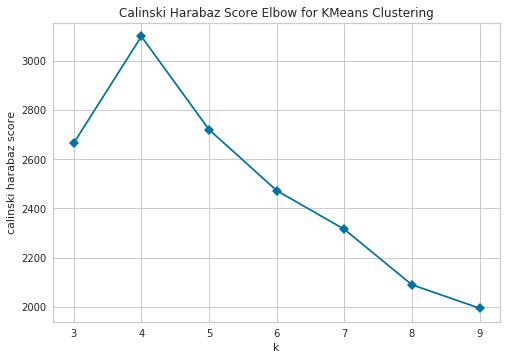

In [9]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(3,10),metric='calinski_harabaz',  timings=False
)


visualizer.fit(df)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [16]:
# create kmeans object and call fit
#Applies Kmeans algorithm
KM = KMeans(n_clusters=4, init='k-means++', random_state=170)
KM = KM.fit(df)
# print("The cluster centroids are: \n", KM.cluster_centers_)
# print("Cluster_label:\n", KM.labels_)

In [17]:
#Based off the results collected, each index corresponds with a HeroID. However, an array starts at 0 which offets
#every monster to the left. Additionally, the dataset not account for hero ID: 24 but there is still a value at index.
#This means that every monster with an original hero id greater than 23 is offset to the left by two. 
#Therefore, the below method brings back the monster to its rightful index
def correctCluster(cluster):
    resultArr = []
    for num in cluster:
        resultArr.append(num+2) if num>23 else resultArr.append(num+1)
    return resultArr

In [18]:
cluster1 = KM.cluster_centers_[0]
cluster2 = KM.cluster_centers_[1]
cluster3 = KM.cluster_centers_[2]
cluster4 = KM.cluster_centers_[3]
# cluster5 = KM.cluster_centers_[4]

#This map's keys would be the cluster's name and each corresponding value would be a tuple of the top 5 hero names
clusterMapName = {}
#This map's keys would be the cluster's name and each corresponding value would be a tuple of the top 5 hero Ids
clusterMapId = {}

##Cluster 1

#The function below sorts the array index from lowest to highest based off the value of each elements
#This means that the first 5 index slots that has highest values will be returned
#For example: given array=[5,1,4,8,0], the result would be [4,1,2,0,3]
A = sorted(range(len(cluster1)), key=lambda i: cluster1[i])[-5:]
top5HerosId = correctCluster(A)
hero1 = searchHeroName(top5HerosId[0])
hero2 = searchHeroName(top5HerosId[1])
hero3 = searchHeroName(top5HerosId[2])
hero4 = searchHeroName(top5HerosId[3])
hero5 = searchHeroName(top5HerosId[4])
clusterMapId['Cluster1'] = (top5HerosId[0],top5HerosId[1],top5HerosId[2],top5HerosId[3],top5HerosId[4])
clusterMapName['Cluster1']=(hero1,hero2,hero3,hero4,hero5)

##Cluster 2
A = sorted(range(len(cluster2)), key=lambda i: cluster2[i])[-5:]
top5HerosId = correctCluster(A)
hero1 = searchHeroName(top5HerosId[0])
hero2 = searchHeroName(top5HerosId[1])
hero3 = searchHeroName(top5HerosId[2])
hero4 = searchHeroName(top5HerosId[3])
hero5 = searchHeroName(top5HerosId[4])
clusterMapId['Cluster2'] = (top5HerosId[0],top5HerosId[1],top5HerosId[2],top5HerosId[3],top5HerosId[4])
clusterMapName['Cluster2']=(hero1,hero2,hero3,hero4,hero5)

##Cluster 3
A = sorted(range(len(cluster3)), key=lambda i: cluster3[i])[-5:]
top5HerosId = correctCluster(A)
hero1 = searchHeroName(top5HerosId[0])
hero2 = searchHeroName(top5HerosId[1])
hero3 = searchHeroName(top5HerosId[2])
hero4 = searchHeroName(top5HerosId[3])
hero5 = searchHeroName(top5HerosId[4])
clusterMapId['Cluster3'] = (top5HerosId[0],top5HerosId[1],top5HerosId[2],top5HerosId[3],top5HerosId[4])
clusterMapName['Cluster3']=(hero1,hero2,hero3,hero4,hero5)

##Cluster 4
A = sorted(range(len(cluster4)), key=lambda i: cluster4[i])[-5:]
top5HerosId = correctCluster(A)
hero1 = searchHeroName(top5HerosId[0])
hero2 = searchHeroName(top5HerosId[1])
hero3 = searchHeroName(top5HerosId[2])
hero4 = searchHeroName(top5HerosId[3])
hero5 = searchHeroName(top5HerosId[4])
clusterMapId['Cluster4'] = (top5HerosId[0],top5HerosId[1],top5HerosId[2],top5HerosId[3],top5HerosId[4])
clusterMapName['Cluster4']=(hero1,hero2,hero3,hero4,hero5)

##Cluster 5
# A = sorted(range(len(cluster5)), key=lambda i: cluster5[i])[-5:]
# top5HerosId = correctCluster(A)
# hero1 = searchHeroName(top5HerosId[0])
# hero2 = searchHeroName(top5HerosId[1])
# hero3 = searchHeroName(top5HerosId[2])
# hero4 = searchHeroName(top5HerosId[3])
# hero5 = searchHeroName(top5HerosId[4])
# clusterMapId['Cluster5'] = (top5HerosId[0],top5HerosId[1],top5HerosId[2],top5HerosId[3],top5HerosId[4])
# clusterMapName['Cluster5']=(hero1,hero2,hero3,hero4,hero5)


In [19]:
#Table of hero names for a given cluster
pd.DataFrame(clusterMapName)

,Cluster1,Cluster2,Cluster3,Cluster4
0,Skywrath Mage,Skywrath Mage,Mirana,Mirana
1,Juggernaut,Tidehunter,Tidehunter,Juggernaut
2,Earth Spirit,Mirana,Skywrath Mage,Skywrath Mage
3,Invoker,Juggernaut,Clockwerk,Tidehunter
4,Venomancer,Zeus,Silencer,Phantom Lancer


In [20]:
#Table of hero ids for a given cluster
resultIds = pd.DataFrame(clusterMapId)
resultIds

,Cluster1,Cluster2,Cluster3,Cluster4
0,101,101,9,9
1,8,29,29,8
2,107,9,101,101
3,74,8,51,29
4,40,22,75,12


In [21]:
#Given a hero id, we return the role that hero plays
def find_role(heroId):
    champ_row = champions.loc[champions["hero_id"] == heroId]
    role =  champ_row["role"]
    role = role.values
    return ''.join(role)

#In the table of hero Ids, we apply the above function into each cell
resultCategory = resultIds.applymap(lambda x: find_role(x))
#A table of what types of roles each cluster has
resultCategory

,Cluster1,Cluster2,Cluster3,Cluster4
0,nuker,nuker,escape,escape
1,carry,initiator,initiator,carry
2,nuker,escape,nuker,nuker
3,nuker,carry,initiator,initiator
4,support,nuker,disabler,carry
